In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.layers import RandomFlip, RandomRotation
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

2025-11-04 19:59:46.797144: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762286387.010156      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762286387.067735      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Define Parameters
BASE_PATH = '/kaggle/input/nail-disease-detection-dataset/data'
TRAIN_PATH = os.path.join(BASE_PATH, 'train')
VAL_PATH = os.path.join(BASE_PATH, 'validation')

IMG_SIZE = (224, 224) # EfficientNetB0 default input size
BATCH_SIZE = 32
SEED = 42

# Data Loading

In [3]:
train_ds = image_dataset_from_directory(
    TRAIN_PATH,
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,  # Important for feature extraction
    seed=SEED
)

val_ds = image_dataset_from_directory(
    VAL_PATH,
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False, # Important for feature extraction
    seed=SEED
)

# Get class names
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Found {num_classes} classes: {class_names}")

Found 3744 files belonging to 6 classes.
Found 91 files belonging to 6 classes.
Found 6 classes: ['Acral_Lentiginous_Melanoma', 'Healthy_Nail', 'Onychogryphosis', 'blue_finger', 'clubbing', 'pitting']


I0000 00:00:1762286400.083288      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762286400.084083      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# Exploratory Data Analysis

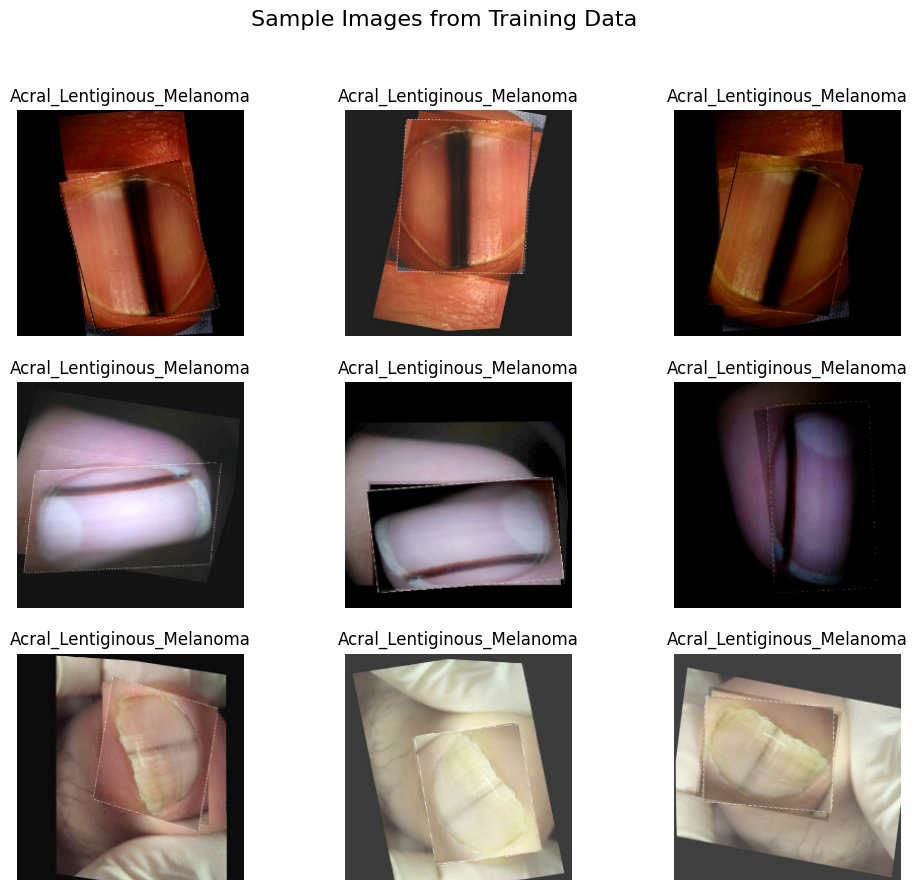

In [4]:
# Sample Images
plt.figure(figsize=(12, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Sample Images from Training Data", fontsize=16)
plt.show()

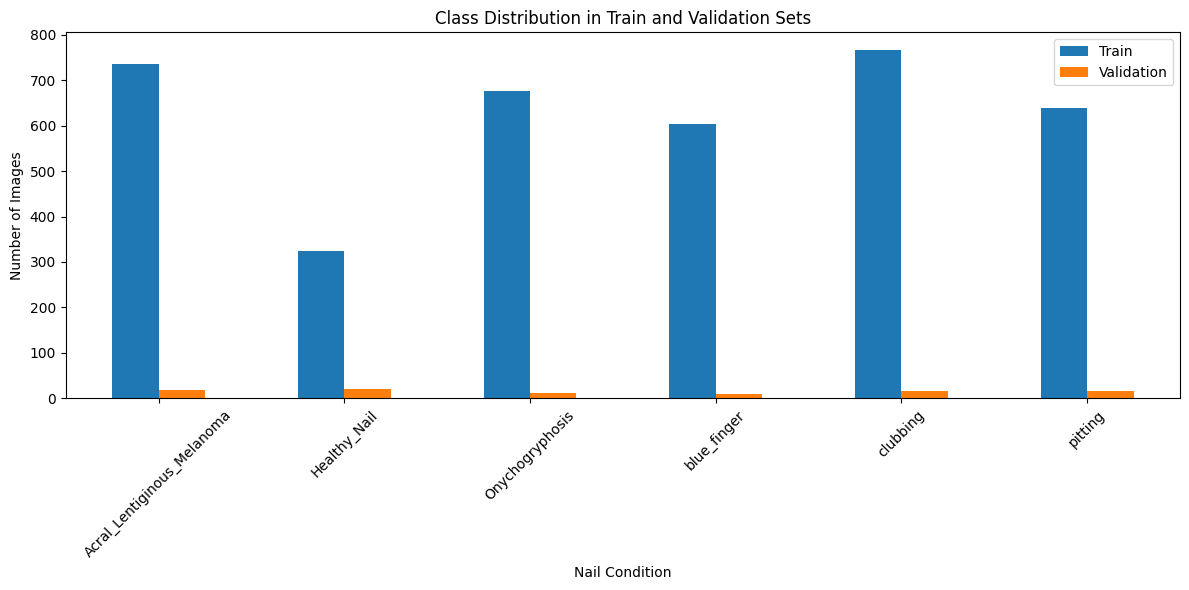


Training set distribution:
Acral_Lentiginous_Melanoma    735
Healthy_Nail                  323
Onychogryphosis               677
blue_finger                   603
clubbing                      767
pitting                       639
Name: Train, dtype: int64


In [5]:
def count_files(directory):
    counts = {}
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        counts[class_name] = len(os.listdir(class_path))
    return counts

train_counts = count_files(TRAIN_PATH)
val_counts = count_files(VAL_PATH)

# Create a DataFrame for plotting
df_counts = pd.DataFrame([train_counts, val_counts], index=['Train', 'Validation']).T

# Plot
df_counts.plot(kind='bar', figsize=(12, 6), rot=45)
plt.title('Class Distribution in Train and Validation Sets')
plt.ylabel('Number of Images')
plt.xlabel('Nail Condition')
plt.tight_layout()
plt.show()

print("\nTraining set distribution:")
print(df_counts['Train'])

# Preprocessing & Feature Extraction (CNN)

In [6]:
# Define Data Augmentation
# We'll build this right into the model
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical", seed=SEED),
    RandomRotation(0.2, seed=SEED),
], name="data_augmentation")

In [7]:
def build_finetuned_model(img_size, num_classes):
    # Load pre-trained EfficientNetB0
    base_model = EfficientNetB0(
        input_shape=img_size + (3,),
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze the base model first
    base_model.trainable = False
    
    # --- Unfreeze the top layers ---
    for layer in base_model.layers[-20:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    # Define the new model
    inputs = Input(shape=img_size + (3,))
    # Apply preprocessing and augmentation
    x = preprocess_input(inputs)
    x = data_augmentation(x)
    
    x = base_model(x, training=True) 
    
    # --- This model has TWO outputs ---
    
    # Output 1: Feature vector
    feature_vector = GlobalAveragePooling2D(name="feature_vector")(x)
    
    # Output 2: Classification head
    classifier_head = Dropout(0.4)(feature_vector)
    classifier_head = Dense(128, activation="relu")(classifier_head)
    outputs = Dense(num_classes, activation="softmax", name="classification_output")(classifier_head)
    
    # --- THIS IS THE FIX ---
    # Return a dictionary of outputs to match the loss dictionary
    model = Model(inputs, outputs={
        "feature_vector": feature_vector, 
        "classification_output": outputs
    })
    
    return model

In [8]:
# Build and Compile
finetune_model = build_finetuned_model(IMG_SIZE, num_classes)

# Compile the model
finetune_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss={
        "classification_output": SparseCategoricalCrossentropy(),
        "feature_vector": None  # Tell Keras to ignore this output for loss
    },
    metrics={
        "classification_output": ["accuracy"]
    }
)

finetune_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_vector                  │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_output (Dense)   │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,313 (16.08 MB)

 Trainable params: 1,507,510 (5.75 MB)

 Non-trainable params: 2,706,803 (10.33 MB)

In [9]:
# Train the Fine-Tuning Model
# We need to adapt the datasets to have a dictionary output
# to match our model's output names
def adapt_dataset(ds):
    return ds.map(lambda x, y: (x, {"classification_output": y}))

train_ds_adapted = adapt_dataset(train_ds)
val_ds_adapted = adapt_dataset(val_ds)

print("\n--- Starting CNN Fine-Tuning ---")
history = finetune_model.fit(
    train_ds_adapted,
    validation_data=val_ds_adapted,
    epochs=15, # Train for a few epochs
    verbose=1
)
print("--- CNN Fine-Tuning Complete ---")


--- Starting CNN Fine-Tuning ---
Epoch 1/15


E0000 00:00:1762286420.436392      37 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1762286422.910841     107 cuda_dnn.cc:529] Loaded cuDNN version 90300


117/117 ━━━━━━━━━━━━━━━━━━━━ 33s 121ms/step - classification_output_accuracy: 0.5565 - loss: 1.6077 - val_classification_output_accuracy: 0.1758 - val_loss: 2.0352
Epoch 2/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - classification_output_accuracy: 0.2184 - loss: 1.9201 - val_classification_output_accuracy: 0.4615 - val_loss: 1.2570
Epoch 3/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - classification_output_accuracy: 0.4771 - loss: 1.4209 - val_classification_output_accuracy: 0.3956 - val_loss: 1.9354
Epoch 4/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - classification_output_accuracy: 0.5290 - loss: 1.5253 - val_classification_output_accuracy: 0.5385 - val_loss: 0.9670
Epoch 5/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - classification_output_accuracy: 0.4411 - loss: 1.2729 - val_classification_output_accuracy: 0.5934 - val_loss: 0.7808
Epoch 6/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - classification_output_accuracy: 0.4706 - loss: 1.1652 - val_classification_output_accurac

In [10]:
# Extract Features from Train and Validation Sets

feature_extractor = Model(
    inputs=finetune_model.input,
    outputs=finetune_model.get_layer("feature_vector").output
)

feature_extractor.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_vector                  │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 1,342,768 (5.12 MB)

 Non-trainable params: 2,706,803 (10.33 MB)

In [11]:
# Extract Features from Train and Validation Sets
def extract_features(dataset, model):
    all_features = []
    all_labels = []

    # Iterate over the dataset
    # We use 'train_ds' (the original) because it yields (images, labels)
    # and we need the labels.
    for images, labels in dataset:
        features = model.predict(images)
        all_features.append(features)
        all_labels.append(labels.numpy())

    # Concatenate all batches
    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    return all_features, all_labels

print("\nExtracting features from *fine-tuned* model...")
# We pass the *original* train_ds and val_ds, NOT the 'adapted' ones.
X_train, y_train = extract_features(train_ds, feature_extractor)

print("Extracting features from validation set...")
X_val, y_val = extract_features(val_ds, feature_extractor)

print(f"\nShape of extracted training features: {X_train.shape}")
print(f"Shape of extracted training labels: {y_train.shape}")
print(f"Shape of extracted validation features: {X_val.shape}")
print(f"Shape of extracted validation labels: {y_val.shape}")


Extracting features from *fine-tuned* model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

# Modelling

In [12]:
X_train_to_fit = X_train
y_train_to_fit = y_train

#  Define the GPC Kernel
# An RBF (Radial Basis Function) kernel is a good default.
# The 'length_scale' is a hyperparameter you can tune.
kernel = 1.0 * RBF(length_scale=1.0)

# 2. Initialize the GPC
# We use one-vs-rest for multi-class, which is the default.
gpc = GaussianProcessClassifier(
    kernel=kernel,
    random_state=SEED
)

#  3. Train the GPC
print("\nTraining Gaussian Process Classifier... (This is the slow part!)")
gpc.fit(X_train_to_fit, y_train_to_fit)
print("GPC training complete.")


Training Gaussian Process Classifier... (This is the slow part!)
GPC training complete.


# Evaluation and Uncertainty Analysis

In [13]:
# Standard Evaluation
print("\n--- Standard Model Evaluation ---")
y_pred = gpc.predict(X_val)

print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=class_names))


--- Standard Model Evaluation ---
Accuracy: 0.2967

Classification Report:
                            precision    recall  f1-score   support

Acral_Lentiginous_Melanoma       0.33      0.06      0.10        18
              Healthy_Nail       0.00      0.00      0.00        20
           Onychogryphosis       0.00      0.00      0.00        12
               blue_finger       1.00      0.67      0.80         9
                  clubbing       1.00      0.25      0.40        16
                   pitting       0.21      1.00      0.34        16

                  accuracy                           0.30        91
                 macro avg       0.42      0.33      0.27        91
              weighted avg       0.38      0.30      0.23        91



In [14]:
from sklearn.ensemble import RandomForestClassifier

print("\n--- Sanity Check: Training Random Forest ---")
rf = RandomForestClassifier(n_estimators=100, random_state=SEED)
rf.fit(X_train, y_train)

print("Random Forest Evaluation:")
y_pred_rf = rf.predict(X_val)
print(classification_report(y_val, y_pred_rf, target_names=class_names))


--- Sanity Check: Training Random Forest ---
Random Forest Evaluation:
                            precision    recall  f1-score   support

Acral_Lentiginous_Melanoma       0.95      1.00      0.97        18
              Healthy_Nail       1.00      1.00      1.00        20
           Onychogryphosis       0.92      1.00      0.96        12
               blue_finger       0.89      0.89      0.89         9
                  clubbing       1.00      0.81      0.90        16
                   pitting       0.94      1.00      0.97        16

                  accuracy                           0.96        91
                 macro avg       0.95      0.95      0.95        91
              weighted avg       0.96      0.96      0.95        91



In [19]:
from sklearn.naive_bayes import GaussianNB

print("\n--- Sanity Check: Training Gaussian Naive Bayes ---")
gnb = GaussianNB()
gnb.fit(X_train, y_train)

print("Gaussian Naive Bayes Evaluation:")
y_pred_gnb = gnb.predict(X_val)
print(classification_report(y_val, y_pred_gnb, target_names=class_names))


--- Sanity Check: Training Gaussian Naive Bayes ---
Gaussian Naive Bayes Evaluation:
                            precision    recall  f1-score   support

Acral_Lentiginous_Melanoma       1.00      1.00      1.00        18
              Healthy_Nail       1.00      1.00      1.00        20
           Onychogryphosis       0.86      1.00      0.92        12
               blue_finger       0.75      1.00      0.86         9
                  clubbing       1.00      0.62      0.77        16
                   pitting       0.94      1.00      0.97        16

                  accuracy                           0.93        91
                 macro avg       0.92      0.94      0.92        91
              weighted avg       0.95      0.93      0.93        91



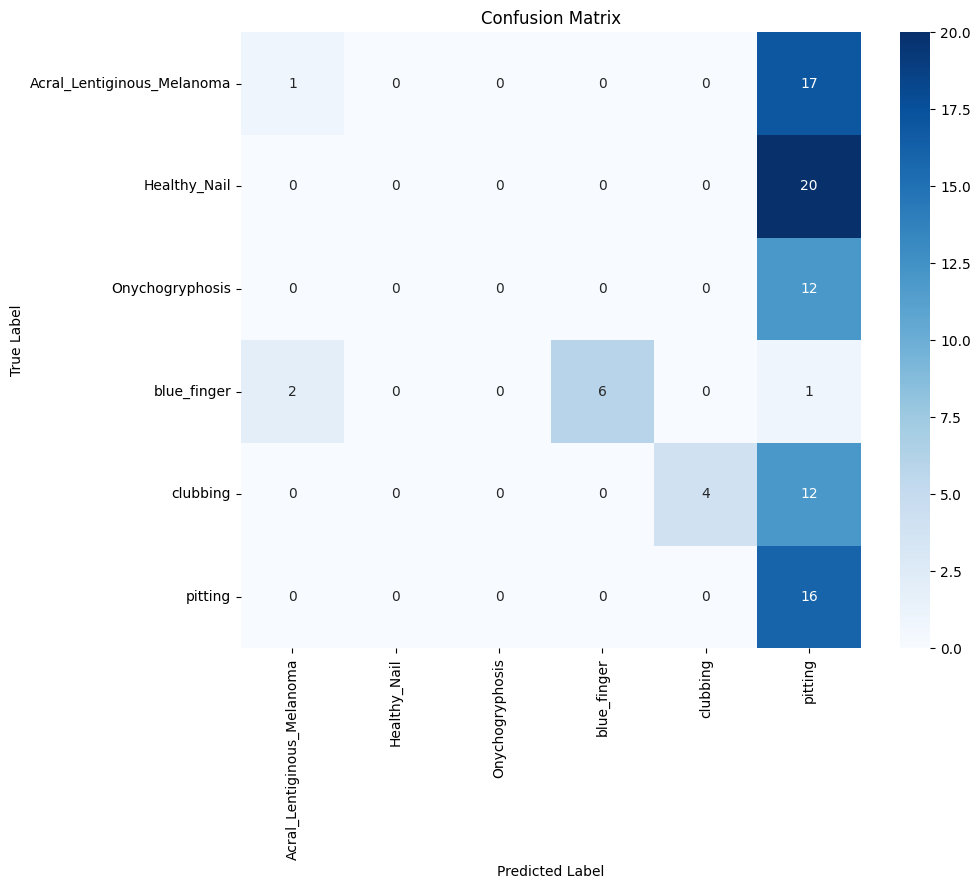

In [15]:
# Plot Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [16]:
# Uncertainty & Outlier Detection Module 
print("\n--- Uncertainty and Outlier Analysis ---")

# Get the probability estimates for each class
# Shape: (n_samples, n_classes)
y_probs = gpc.predict_proba(X_val)

# The "uncertainty" can be defined as the confidence in the top prediction.
# A low confidence (e.g., < 0.5) means the GPC is "uncertain".
y_confidence = np.max(y_probs, axis=1)

# This is a critical hyperparameter.
# Let's flag any prediction where the model is less than 60% confident.
UNCERTAINTY_THRESHOLD = 0.60

outlier_indices = np.where(y_confidence < UNCERTAINTY_THRESHOLD)[0]
print(f"Found {len(outlier_indices)} 'uncertain' or 'outlier' samples in the validation set.")


--- Uncertainty and Outlier Analysis ---
Found 91 'uncertain' or 'outlier' samples in the validation set.


In [17]:
# Visualize Uncertain Predictions 
# We need to get the original images from the val_ds
val_images = []
val_labels_list = []
for img, lab in val_ds.unbatch():
    val_images.append(img.numpy().astype("uint8"))
    val_labels_list.append(lab.numpy())

val_images = np.array(val_images)
val_labels_list = np.array(val_labels_list)

Displaying samples flagged by the Outlier Detection Module:


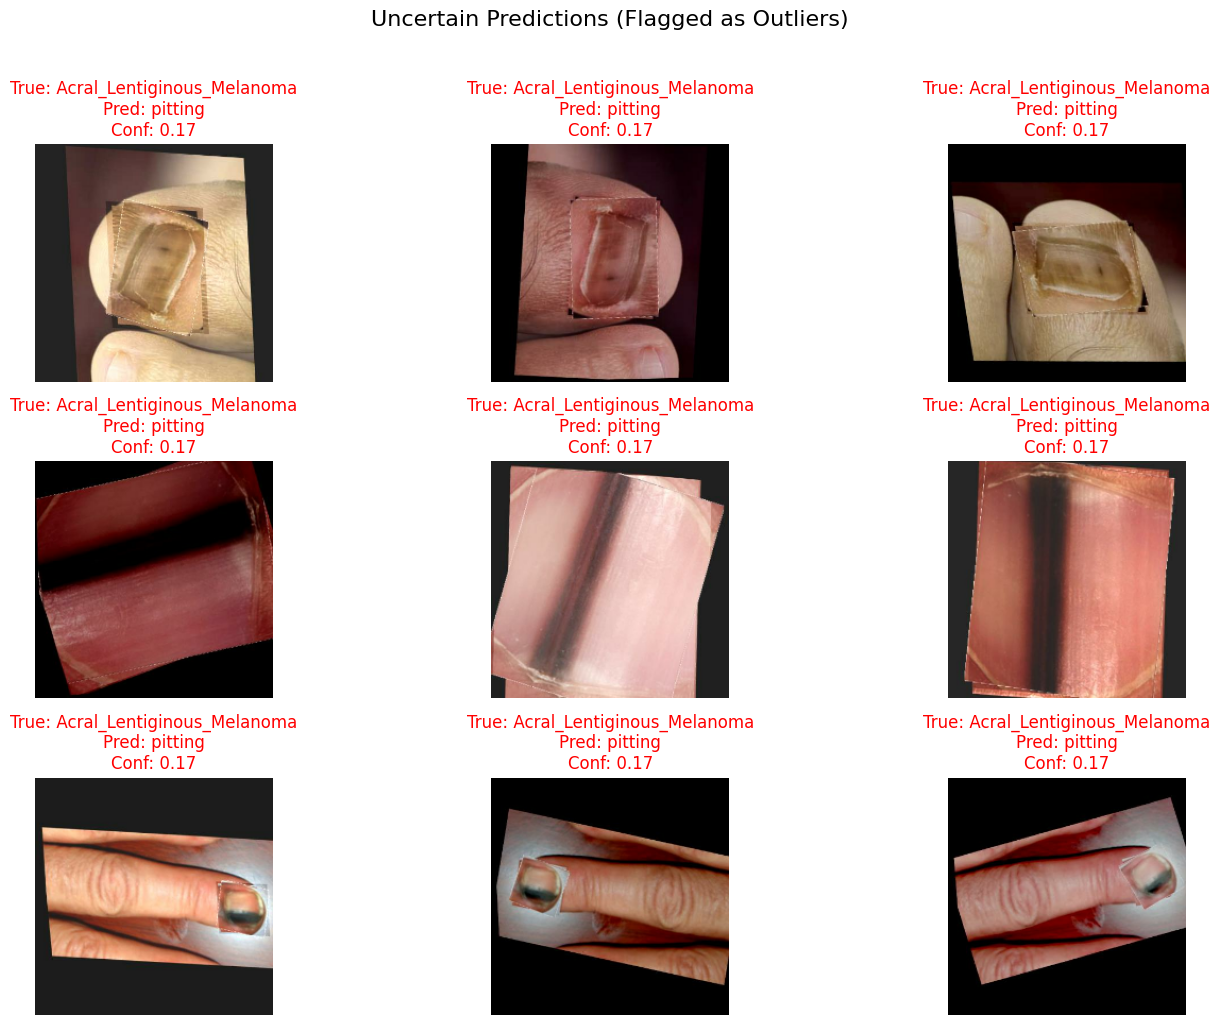

In [18]:
# Plot the first few "outliers"
print("Displaying samples flagged by the Outlier Detection Module:")
plt.figure(figsize=(15, 10))
plot_count = 0
for i in outlier_indices[:9]: # Show the first 9 outliers
    ax = plt.subplot(3, 3, plot_count + 1)
    
    # Get the image, true label, and prediction info
    img = val_images[i]
    true_label = class_names[val_labels_list[i]]
    pred_label = class_names[y_pred[i]]
    confidence = y_confidence[i]
    
    plt.imshow(img)
    plt.axis("off")
    
    title_color = 'red' # Flag as red
    plt.title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}",
              color=title_color)
    
    plot_count += 1
    
plt.suptitle("Uncertain Predictions (Flagged as Outliers)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()